#### Importamos las bibliotecas necesarias para realizar la práctica.

In [93]:
import os, glob

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data

import torchvision.transforms as transforms
from torchvision.io import read_image

from torchvision.models import squeezenet1_0
from torch import nn

from sklearn.model_selection import train_test_split

from torchvision.models import squeezenet1_0, SqueezeNet1_0_Weights




## **Tarea 1**: Implementación de Dataset class personalizada para la carga del dataset y su uso en tareas de clasificación.

#### Creamos una clase `Dataset` que hereda de `torch.utils.data.Dataset`. Esta clase se utiliza para cargar imágenes y sus etiquetas desde un directorio y un archivo CSV, respectivamente. También aplica transformaciones a las imágenes.

In [78]:
class Dataset(data.Dataset):
    def __init__(self, image_path, csv_path, transform=None):
        super().__init__()
        self.img_files = glob.glob(os.path.join(image_path, "*.jpg")) + glob.glob(os.path.join(image_path, "*.png"))
        print("Imágenes en .jpg y .png:", len(self.img_files))

        # leemos el csv y recortamos la cabecera
        self.labels = open(csv_path).readlines()[1:]
        
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.ToTensor()])

    def __getitem__(self, index):
        img_path = self.img_files[index]

        name = os.path.splitext(os.path.basename(img_path))[0]

        image = read_image(img_path)
        image = self.transform(image)
        
        # nos quedamos solo con la etiqueta binaria
        line = self.labels[index].strip()
        _, label = line.split(";")
        label = torch.tensor(int(label), dtype=torch.float32)

        return image, label, name

    def __len__(self):
        return len(self.img_files)

#### Definimos dos funciones: `tensor_to_image` para convertir un tensor en una imagen de NumPy y `show` para mostrar una imagen utilizando Matplotlib.

In [79]:
def tensor_to_image(tensor):
    new_image = np.empty( (tensor.size()[1], tensor.size()[2]) )
    new_image[:,:] = tensor[0,:,:]
    return new_image

def show(image, title=None):
    plt.imshow(image, cmap="grey")
    plt.axis('off')
    if title:
        plt.suptitle(title)
    plt.show()

#### Indicamos el directorio de las imágenes y el archivo CSV de etiquetas. Creamos transformaciones personalizadas para las imágenes e instanciamos el dataset ship_dataset. Finalmente, imprimimos el tamaño del dataset.

In [80]:
dir = "ship_dataset/"
label_csv_filename = "ship.csv"

my_transforms = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((144, 256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5,))
])

ship_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=my_transforms)
print("Tamaño del dataset completo:", len(ship_dataset))

Imágenes en .jpg y .png: 294
Tamaño del dataset completo: 294


####  Obtenemos una imagen, su etiqueta y su nombre del dataset en el índice 160. Después, mostramos la imagen utilizando la función `show`.

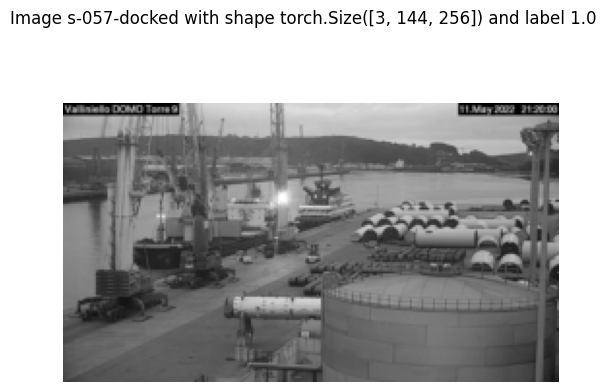

In [81]:
image, label, name = ship_dataset[160]
show(tensor_to_image(image), title=f"Image {name} with shape {image.shape} and label {label}")

#### Instanciamos el modelo `squeezenet1_0` de `torchvision.models`

In [82]:
model = squeezenet1_0()
#print(model)

#### Definimos un modelo secuencial `mymodel` utilizando las características de `squeezenet1_0` y se agregan capas adicionales. La imagen se expande en dimensión para ser compatible con el modelo y obtenemos la salida del modelo. Por último, imprimimos las formas de la imagen y la salida.

In [83]:
mymodel = nn.Sequential(
    model.features,
    nn.AdaptiveAvgPool2d(output_size = 1),
    nn.Flatten(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1),
)

image = image.unsqueeze(0)

output = mymodel(image)

print(image.shape)
print(output.shape)

torch.Size([1, 3, 144, 256])
torch.Size([1, 1])


## **Tarea 2**: Clasificación Ship/No-ship. Dada una imagen de entrada predecir la presencia o ausencia de barcos en la escena. Partiendo de un modelo de red base:

### Entrenamiento y validación desde cero, con y sin data augmentation (2 modelos)

####

In [ ]:
# Dividimos el dataset en entrenamiento y validación
train_indices, val_indices = train_test_split(list(range(len(ship_dataset))), test_size=0.2, random_state=42)

train_dataset = data.Subset(ship_dataset, train_indices)
val_dataset = data.Subset(ship_dataset, val_indices)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=False)

#### Sin Data Augmentation

In [ ]:
# Definimos el modelo
model = nn.Sequential(
    squeezenet1_0().features,
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1),
    nn.Sigmoid()
)

# Definimos la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenamos el modelo
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for images, labels, _ in train_loader:
        labels = labels.unsqueeze(1)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validamos el modelo
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels, _ in val_loader:
            labels = labels.unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

Epoch [1/20], Loss: 0.6742, Val Loss: 0.6738
Epoch [2/20], Loss: 0.6805, Val Loss: 0.6795
Epoch [3/20], Loss: 0.6690, Val Loss: 0.6645
Epoch [4/20], Loss: 0.6537, Val Loss: 0.6538
Epoch [5/20], Loss: 0.6100, Val Loss: 0.6159
Epoch [6/20], Loss: 0.5658, Val Loss: 0.5733
Epoch [7/20], Loss: 0.6186, Val Loss: 0.6183
Epoch [8/20], Loss: 0.5068, Val Loss: 0.5412
Epoch [9/20], Loss: 0.5295, Val Loss: 0.5291
Epoch [10/20], Loss: 0.4560, Val Loss: 0.4478
Epoch [11/20], Loss: 0.3304, Val Loss: 0.4091
Epoch [12/20], Loss: 0.3078, Val Loss: 0.3525
Epoch [13/20], Loss: 0.3858, Val Loss: 0.3886
Epoch [14/20], Loss: 0.3587, Val Loss: 0.3745
Epoch [15/20], Loss: 0.3212, Val Loss: 0.3535
Epoch [16/20], Loss: 0.1949, Val Loss: 0.2798
Epoch [17/20], Loss: 0.1403, Val Loss: 0.3087
Epoch [18/20], Loss: 0.1518, Val Loss: 0.4592
Epoch [19/20], Loss: 0.3240, Val Loss: 0.6882
Epoch [20/20], Loss: 0.1379, Val Loss: 0.3573


#### Con Data Augmentation

In [ ]:
# Definimos las transformaciones con redimensionamiento y data augmentation
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # Redimensionamos todas las imágenes a 256x256
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Creamos un nuevo dataset con el data augmentation
augmented_ship_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=train_transforms)

# Dividimos el dataset en entrenamiento y validación
train_indices, val_indices = train_test_split(list(range(len(augmented_ship_dataset))), test_size=0.2, random_state=42)

train_dataset = data.Subset(augmented_ship_dataset, train_indices)
val_dataset = data.Subset(augmented_ship_dataset, val_indices)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Definimos el modelo
model = nn.Sequential(
    squeezenet1_0().features,
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1),
    nn.Sigmoid()
)

# Definimos la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenamos el modelo con data augmentation
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for images, labels, _ in train_loader:
        labels = labels.unsqueeze(1)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validamos el modelo
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels, _ in val_loader:
            labels = labels.unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

Imágenes en .jpg y .png: 294
Epoch [1/20], Loss: 0.6750, Val Loss: 0.6719
Epoch [2/20], Loss: 0.6615, Val Loss: 0.6576
Epoch [3/20], Loss: 0.6788, Val Loss: 0.6786
Epoch [4/20], Loss: 0.6546, Val Loss: 0.6526
Epoch [5/20], Loss: 0.6435, Val Loss: 0.6379
Epoch [6/20], Loss: 0.6132, Val Loss: 0.6088
Epoch [7/20], Loss: 0.8188, Val Loss: 0.8302
Epoch [8/20], Loss: 0.5929, Val Loss: 0.6022
Epoch [9/20], Loss: 0.5965, Val Loss: 0.6061
Epoch [10/20], Loss: 1.0017, Val Loss: 0.9433
Epoch [11/20], Loss: 0.6699, Val Loss: 0.6674
Epoch [12/20], Loss: 0.6531, Val Loss: 0.6591
Epoch [13/20], Loss: 0.6957, Val Loss: 0.7374
Epoch [14/20], Loss: 0.6013, Val Loss: 0.6101
Epoch [15/20], Loss: 0.5976, Val Loss: 0.6431
Epoch [16/20], Loss: 0.5000, Val Loss: 0.5382
Epoch [17/20], Loss: 0.6776, Val Loss: 0.6303
Epoch [18/20], Loss: 0.5117, Val Loss: 0.5212
Epoch [19/20], Loss: 0.6240, Val Loss: 0.6977
Epoch [20/20], Loss: 0.5997, Val Loss: 0.5696


### Refinamiento y validación de modelo preentrenado, con y sin data augmentation (2 modelos).

### Sin Data Augmentation

In [ ]:
# Cargamos un modelo preentrenado con el nuevo parámetro 'weights'
weights = SqueezeNet1_0_Weights.IMAGENET1K_V1
pretrained_model = squeezenet1_0(weights=weights)

# Modificamos la última capa del modelo
pretrained_model.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
pretrained_model.num_classes = 1

# Definimos la función de pérdida y el optimizador
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.001)

# Entrenamos el modelo preentrenado
num_epochs = 20
for epoch in range(num_epochs):
    pretrained_model.train()
    for images, labels, _ in train_loader:
        labels = labels.float().unsqueeze(1)
        outputs = pretrained_model(images)
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validamos el modelo
    pretrained_model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels, _ in val_loader:
            labels = labels.float().unsqueeze(1)
            outputs = pretrained_model(images)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

Epoch [1/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [2/20], Loss: 0.6783, Val Loss: 0.6786
Epoch [3/20], Loss: 0.6859, Val Loss: 0.6859
Epoch [4/20], Loss: 0.6931, Val Loss: 0.6931
Epoch [5/20], Loss: 0.6927, Val Loss: 0.6926
Epoch [6/20], Loss: 0.6826, Val Loss: 0.6824
Epoch [7/20], Loss: 0.6238, Val Loss: 0.6277
Epoch [8/20], Loss: 0.6534, Val Loss: 0.6612
Epoch [9/20], Loss: 0.6412, Val Loss: 0.6510
Epoch [10/20], Loss: 0.6518, Val Loss: 0.6537
Epoch [11/20], Loss: 0.5942, Val Loss: 0.5998
Epoch [12/20], Loss: 0.5243, Val Loss: 0.5561
Epoch [13/20], Loss: 0.5298, Val Loss: 0.5445
Epoch [14/20], Loss: 0.6408, Val Loss: 0.6473
Epoch [15/20], Loss: 0.5665, Val Loss: 0.6196
Epoch [16/20], Loss: 0.6041, Val Loss: 0.6078
Epoch [17/20], Loss: 0.5437, Val Loss: 0.5561
Epoch [18/20], Loss: 0.5296, Val Loss: 0.5658
Epoch [19/20], Loss: 0.4724, Val Loss: 0.5269
Epoch [20/20], Loss: 0.4214, Val Loss: 0.5087


#### Con Data Augmentation

In [ ]:
# Creamos un nuevo dataset con el data augmentation
augmented_ship_dataset = Dataset(f"{dir}/images", f"{dir}/{label_csv_filename}", transform=train_transforms)

# Dividimos el dataset en entrenamiento y validación
train_indices, val_indices = train_test_split(list(range(len(augmented_ship_dataset))), test_size=0.2, random_state=42)

train_dataset = data.Subset(augmented_ship_dataset, train_indices)
val_dataset = data.Subset(augmented_ship_dataset, val_indices)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Entrenamos el modelo preentrenado con data augmentation
num_epochs = 20
for epoch in range(num_epochs):
    pretrained_model.train()
    for images, labels, _ in train_loader:
        labels = labels.float().unsqueeze(1)
        outputs = pretrained_model(images)
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validamos el modelo
    pretrained_model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels, _ in val_loader:
            labels = labels.float().unsqueeze(1)
            outputs = pretrained_model(images)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

Imágenes en .jpg y .png: 294
Epoch [1/20], Loss: 0.4223, Val Loss: 0.6000
Epoch [2/20], Loss: 0.4602, Val Loss: 0.6438
Epoch [3/20], Loss: 0.4950, Val Loss: 0.5230
Epoch [4/20], Loss: 0.4427, Val Loss: 0.4995
Epoch [5/20], Loss: 0.4775, Val Loss: 0.5240
Epoch [6/20], Loss: 0.4420, Val Loss: 0.5030
Epoch [7/20], Loss: 0.4538, Val Loss: 0.6288
Epoch [8/20], Loss: 0.4781, Val Loss: 0.7141
Epoch [9/20], Loss: 0.4796, Val Loss: 2.1135
Epoch [10/20], Loss: 0.4916, Val Loss: 0.7756
Epoch [11/20], Loss: 0.5207, Val Loss: 0.7364
Epoch [12/20], Loss: 0.3922, Val Loss: 2.0825
Epoch [13/20], Loss: 0.4272, Val Loss: 0.6333
Epoch [14/20], Loss: 0.3800, Val Loss: 0.6098
Epoch [15/20], Loss: 0.4096, Val Loss: 2.1471
Epoch [16/20], Loss: 0.8690, Val Loss: 2.5879
Epoch [17/20], Loss: 0.4575, Val Loss: 0.6561
Epoch [18/20], Loss: 0.3955, Val Loss: 0.6362
Epoch [19/20], Loss: 0.4517, Val Loss: 0.5230
Epoch [20/20], Loss: 0.3784, Val Loss: 0.5910
